# determine nominal BGS exposure time from spectral simulations
In this notebook, we will use BGS spectral simulations to determine the nominal exposure time. We define nominal exposure time as the exposure time required to achieve 95% redshift success for objects brighter than r<19.5 during **nominal dark conditions**. 

This notebook is meant to be run on [jupyter.nersc.gov](https://jupyter.nersc.gov/) using the `master` DESI jupyter kernel. See [wiki page](https://desi.lbl.gov/trac/wiki/Computing/JupyterAtNERSC) for details on using jupyter on NERSC and how to set up a DESI jupyter kernel.

If you have any issues with running this notebook, please let me know on the DESI slack channel or by e-mail at changhoon.hahn@princeton.edu 

In [1]:
# first lets install the python package `feasibgs`, a python package for the BGS spectral simulations
!pip install git+https://github.com/desi-bgs/feasiBGS.git --upgrade

Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/desi-bgs/feasiBGS.git to /tmp/pip-req-build-kj1n1dug
  Running command git clone -q https://github.com/desi-bgs/feasiBGS.git /tmp/pip-req-build-kj1n1dug
  Created wheel for feasibgs: filename=feasibgs-0.1-py3-none-any.whl size=47421 sha256=d3682874ec702d52cb79d2f83d3e4d04d11eb07551b88515b77f132c962c0c75
  Stored in directory: /tmp/pip-ephem-wheel-cache-1rwzv4g9/wheels/f7/d7/9d/824c3b88b5bd8c28b8c576f20984e3cf31a80def7e3deae10a
Successfully built feasibgs
  Attempting uninstall: feasibgs
    Found existing installation: feasibgs 0.1
    Uninstalling feasibgs-0.1:
      Successfully uninstalled feasibgs-0.1


In [2]:
import os, sys
import numpy as np

In [3]:
# add the directory where feasibgs was installed to the python path
sys.path.append(os.path.join(os.environ['HOME'], '.local/lib/python3.8/site-packages'))

In [4]:
import os 
import numpy as np 
import fitsio
# --- feasibgs --- 
from feasibgs import util as UT
from feasibgs import cmx as BGS_cmx
from feasibgs import spectral_sims as BGS_spec_sim
from feasibgs import forwardmodel as FM 

In [5]:
# for making pretty plots 
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

# load nominal dark sky
I've implemented a function in `feasibgs.spectral_sims` to quickly read in the nominal dark sky surface brightness. 

In [6]:
Idark = BGS_spec_sim.nominal_dark_sky()

(0.0, 10.0)

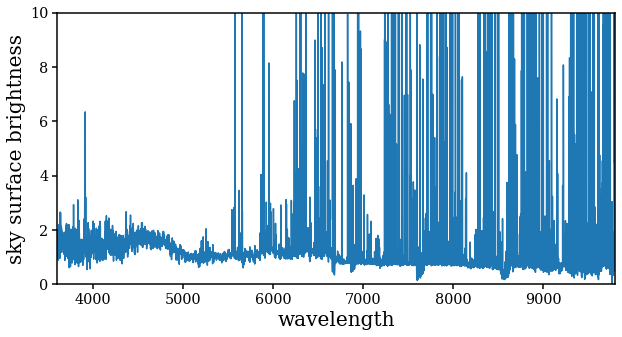

In [7]:
fig = plt.figure(figsize=(10,5))
sub = fig.add_subplot(111)
sub.plot(Idark[0].value, Idark[1].value)
sub.set_xlabel('wavelength', fontsize=20)
sub.set_xlim(3.6e3, 9.8e3)
sub.set_ylabel('sky surface brightness', fontsize=20)
sub.set_ylim(0., 10)

# generate BGS spectral simulations
We've read in the sky brightness for the exposure we want to simulate. Next we'll use the BGS spectral simulation to simulate spectra for this exposure. 

We begin by reading in noiseless BGS source spectra then run it through the `feasibgs` forward model. For details on how the BGS source spectra are constructed see [`feasibgs/spectral_sims.py`](https://github.com/desi-bgs/feasiBGS/blob/63975b1e60f6f93f3b5020ee51ca565f325b918d/feasibgs/spectral_sims.py#L38)

In [8]:
# function for reading in BGS source spectra
BGS_spec_sim.simulated_GAMA_source_spectra?

Signature: BGS_spec_sim.simulated_GAMA_source_spectra(emlines=True)
Docstring:
read GAMA-matched fiber-magnitude scaled BGS source spectra 
These source spectra are created for GAMA objects. their spectra is 
constructed from continuum that's template matched to the broadband
colors and emission lines from GAMA data (properly flux calibrated). 
Then the spectra is scaled down to the r-band fiber magnitude. They 
therefore do not require fiber acceptance fractions. 
File:      ~/.local/lib/python3.8/site-packages/feasibgs/spectral_sims.py
Type:      function


In [9]:
# read in source wavelength, flux, and galaxy properties. 
wave_s, flux_s, prop = BGS_spec_sim.simulated_GAMA_source_spectra(emlines=True) 

In [10]:
# extract true redshift and r-band magnitude for the simulated galaxies
ztrue = prop['zred'] # redshift
r_mag = prop['r_mag'] # Legacy Survey r mag

## BGS forward model
Now we can run these source spectra through the BGS forward model with nominal dark sky and different exposure times

In [11]:
fdesi = FM.fakeDESIspec()

In [12]:
for exptime in [150, 160, 170, 180, 190]: 
    fspec = 'bgs_spectral_sim.nominal_dark.texp%.fs.fits' % exptime
    if os.path.isfile(fspec): continue 
    bgs = fdesi.simExposure(
        wave_s, 
        flux_s, 
        exptime=exptime, 
        airmass=1.1, 
        Isky=[Idark[0].value, Idark[1].value], 
        filename=fspec
    )

(-5.0, 10.0)

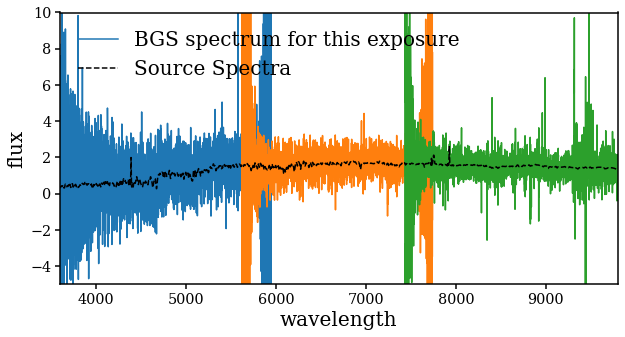

In [13]:
fig = plt.figure(figsize=(10,5))
sub = fig.add_subplot(111)
for band in ['b', 'r', 'z']: 
    sub.plot(bgs.wave[band], bgs.flux[band][1], label={'b': 'BGS spectrum for this exposure', 'r':None, 'z':None}[band])
sub.plot(wave_s, flux_s[1], c='k', ls='--', label='Source Spectra')
sub.legend(loc='upper left', fontsize=20)
sub.set_xlabel('wavelength', fontsize=20)
sub.set_xlim(3.6e3, 9.8e3)
sub.set_ylabel('flux', fontsize=20)
sub.set_ylim(-5, 10)

# run `redrock` on spectral sims
Now that we have a simulated BGS spectra, lets run them through `redrock`. This will take a while so go grab a coffee ... or twenty...

In [19]:
for exptime in [150, 160, 170, 180, 190]: 
    f_spec = 'bgs_spectral_sim.nominal_dark.texp%.fs.fits' % exptime
    f_rr_h5 = 'redrock.bgs_spectral_sim.nominal_dark.texp%.fs.h5' % exptime
    f_rr = 'zbest.bgs_spectral_sim.nominal_dark.texp%.fs.fits' % exptime
    if os.path.isfile(f_rr): continue 
    !rrdesi -o $f_rr_h5 -z $f_rr $f_spec

# calculate and compare redshift success rates
We can now use outputs from `redrock` to estimate the BGS redshift success rate for the different exposure times and determine which meets the 95% redshift success rate requirement. 

We'll be using a number of convenience functions in `feasibgs`.

In [20]:
zsuccesses = [] 
for exptime in [150, 160, 170, 180, 190]: 
    # read redrock output
    frr = 'zbest.bgs_spectral_sim.nominal_dark.texp%.fs.fits' % exptime
    rr = fitsio.read(frr)

    # redshift success defined as |z_redrock - z_true|/(1+z_true) < 0.003 and ZWARN flag = 0 
    zsuccess = UT.zsuccess(rr['Z'], ztrue, rr['ZWARN'], deltachi2=rr['DELTACHI2'], min_deltachi2=40)
    zsuccesses.append(zsuccess)

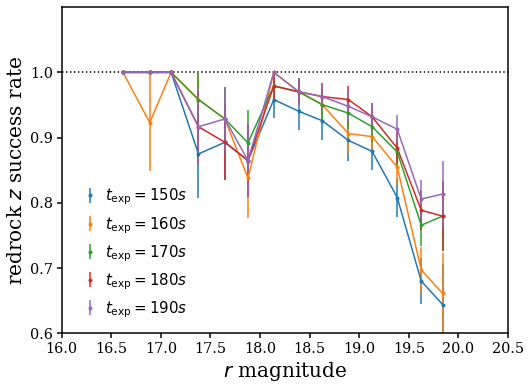

In [21]:
fig = plt.figure(figsize=(8,6))
sub = fig.add_subplot(111)
sub.plot([16, 21], [1, 1], c='k', ls=':')

for i, exptime in enumerate([150, 160, 170, 180, 190]): 
    # calculate redshift success rate
    wmean, rate, err_rate = UT.zsuccess_rate(r_mag, zsuccesses[i], range=[15, 22], nbins=28, bin_min=10)
    sub.errorbar(wmean, rate, err_rate, fmt='.C%i' % i, label=r'$t_{\rm exp} = %.fs$' % exptime)
    sub.plot(wmean, rate, c='C%i' % i)
sub.legend(loc='lower left', handletextpad=0., fontsize=15)
sub.set_xlabel('$r$ magnitude', fontsize=20)
sub.set_xlim(16, 20.5)
sub.set_ylabel('redrock $z$ success rate', fontsize=20)
sub.set_ylim(0.6, 1.1)
sub.set_yticks([0.6, 0.7, 0.8, 0.9, 1.])